# Second Order with Interaction Terms Regression Analysis

### This notebook fits the house price data with second order with interation term regression models in order to predict the house sale price using the features that were prepared in the preceding step.

In [1]:
# First import relevant libraries:
import pandas as pd
from sklearn.model_selection import train_test_split # for model validation
import statsmodels.api as sm # for viewing p-values for model coefficients (note that sklearn LinearRegression does not output this information)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load transformed and normalized data:
train_SOIR = pd.read_csv('train_sec_order.csv')

#### First iteration of second order with interaction terms regression using all features

Similar to what was done with the first order regression, start by using all of the available prepared features. Again, the model fitting will be done using the OLS functino in the statsmodels package so that a pseudo-backwards elimination can be done to prune coefficients that are not significant.

In [3]:
# Copy train data into new dataframe
train_SOIR_iter1 = train_SOIR.copy()

In [4]:
# Obtain a list of column names to split the data into X and y
train_SOIR_iter1_col_list = train_SOIR_iter1.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_SOIR_iter1 = train_SOIR_iter1.loc[:,train_SOIR_iter1_col_list[1]:train_SOIR_iter1_col_list[-1]]
# Now store the first column as y
y_SOIR_iter1 = train_SOIR_iter1.loc[:,train_SOIR_iter1_col_list[0]]
# Split data into training and validation sets:
X_SOIR_iter1_train, X_SOIR_iter1_validate, y_SOIR_iter1_train, y_SOIR_iter1_validate = train_test_split(X_SOIR_iter1, y_SOIR_iter1, test_size = 0.2, random_state = 42, shuffle = True)

In [5]:
# Linear regression in statsmodels requires a column corresponding to the constant in the model, so add this column to both the training and validation sets:
X_SOIR_iter1_train_const = sm.add_constant(X_SOIR_iter1_train)
X_SOIR_iter1_validate_const = sm.add_constant(X_SOIR_iter1_validate)

In [6]:
# Train & fit the model using the training data:
model_SOIR_iter1 = sm.OLS(y_SOIR_iter1_train, X_SOIR_iter1_train_const)
results_SOIR_iter1 = model_SOIR_iter1.fit()
# Print results summary
print(results_SOIR_iter1.summary())

# Define a function to also calculate and print RMSE and R^2 for fits of both the training and validation data
def RMSE_and_R_sq(model_results, X_train_const, X_validate_const, y_train, y_validate):
    # training set:
    y_train_predict = model_results.predict(X_train_const)
    RMSE_train = mean_squared_error(y_train, y_train_predict, squared = False)
    R_squared_train = r2_score(y_train, y_train_predict)
    print('\nThe training set RMSE error is:', round(RMSE_train, ndigits = 4))
    print('The training set R^2 is:', round(R_squared_train, ndigits = 3))
    # validation set:
    y_validate_predict = model_results.predict(X_validate_const)
    RMSE_validate = mean_squared_error(y_validate, y_validate_predict, squared = False)
    R_squared_validate = r2_score(y_validate, y_validate_predict)
    print('\nThe validation set RMSE error is:', round(RMSE_validate, ndigits = 4))
    print('The validation set R^2 is:', round(R_squared_validate, ndigits = 3))
RMSE_and_R_sq(results_SOIR_iter1, X_SOIR_iter1_train_const, X_SOIR_iter1_validate_const, y_SOIR_iter1_train, y_SOIR_iter1_validate)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     75.53
Date:                Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:37:18   Log-Likelihood:                 1765.6
No. Observations:                 952   AIC:                            -3275.
Df Residuals:                     824   BIC:                            -2653.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [7]:
# Define a function to plot model residuals:
def plot_residuals(model_results, y, model_iteration):
    resid = model_results.resid
    resid_plot = pd.concat([y, resid], axis = 1, ignore_index = True)
    resid_plot = resid_plot.rename(columns = {0:'Actual', 1:'Residual'})
    sns.set(rc = {'figure.figsize':(10,8)})
    sns.scatterplot(data = resid_plot, x = 'Actual', y = 'Residual')
    plt.title(f'2nd-order + Interaction Regression {model_iteration} Model SalePrice Residuals')
    plt.xlabel('Normalized Actual SalePrice')
    
# Define a fucntion to plot the calculated residuals using the validation set:
def plot_validation_residuals(model_results, X_validate, y_validate, model_iteration):
    predicted = model_results.predict(X_validate)
    resid = y_validate - predicted
    resid_plot = pd.concat([y_validate, resid], axis = 1, ignore_index = True)
    resid_plot = resid_plot.rename(columns = {0:'Actual', 1:'Residual'})
    sns.set(rc = {'figure.figsize':(10,8)})
    sns.scatterplot(data = resid_plot, x = 'Actual', y = 'Residual')
    plt.title(f'2nd-order + Interaction Regression {model_iteration} Validation SalePrice Residuals')
    plt.xlabel('Normalized Actual SalePrice')

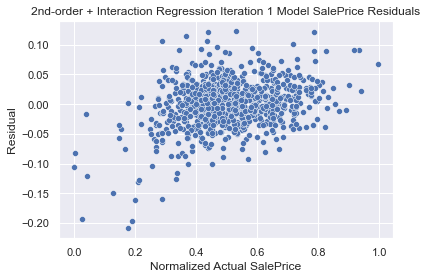

In [8]:
plot_residuals(results_SOIR_iter1, y_SOIR_iter1_train, 'Iteration 1')

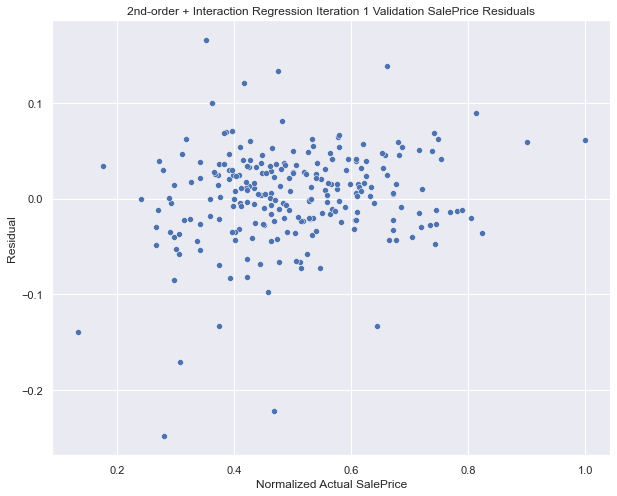

In [9]:
plot_validation_residuals(results_SOIR_iter1, X_SOIR_iter1_validate_const, y_SOIR_iter1_validate, 'Iteration 1')

Examining the results from this first iteration:
- As with the first iteration of the linear regression, there is a note at the end of the results summary indicating collinearity could be a problem. Once again, the features responsible are BsmtQual / BsmtCond and Fireplaces / FireplaceQu. Here, unlike in the first iteration of the linear regresion, all of these features have coefficients that are significant at 90% confidence (the cutoff used for the first iteration of fitting). So which are removed will need to based which features result in a better fit. Although not shown here, this was found to be with BsmtQual and Fireplaces, so BsmtCond and FireplaceQu will be dropped in the next iteration of the model.
- As was mentioned above, 90% confidence will be used as the limit to remove coefficients after the first fitting iteration. (Like the linear regression, 95% confidence will be used as the limit after the next iteration.) The features that do not have significant coefficients at 90% confidence (p > 0.10) are:
    - 1st order: LotShape, LotConfig, RoofStyle, Exterior1st, ExterQual, MoSold
    - 2nd order & interations: LotFrontage^2, LotFrontage + LotArea, LotFrontage + YearBuilt, LotFrontage + GrLivArea, LotArea^2, LotArea + GrLivArea, YearBuilt^2, YearBuilt + GrLivArea, GrLivArea + OverallQual, OverallQual^2
    - Model hierarchy is being maintained: this means that lower order continuous features that are not significant will be retained in the model if there is a higher order (or interation) term that contains this feature. For example, LotArea is not significant at 90% confidence, but the LotArea + YearBuilt interaction is, so LotArea is retained in the model.
- The residual plot looks quite similar to the one from the linear regression, suggesting a second order regression model is fitting the data about the same as the first order regression model.
- The validation set RMSE score is slightly lower than the any of the linear regression validation set RMSE scores. This may mean that this model will fit the data better (although the validation set RMSE score was not a perfect predictor for the test set score either).

#### Second iteration of second order with interaction terms regression with some features removed:

In [10]:
# Copy the training data once again into a new dataframe
train_SOIR_iter2 = train_SOIR.copy()

In [11]:
# Store a list of the 1st order and interaction features that are not significant in a tuple
SOIR_iter2_insig = ('LotShape',
                    'LotConfig',
                    'RoofStyle',
                    'Exterior1st',
                    'ExterQual',
                    'FireplaceQu',
                    'MoSold',
                    'BsmtCond',
                    'LotFrontage + LotArea',
                    'LotFrontage + YearBuilt',
                    'LotFrontage + GrLivArea',
                    'LotArea + GrLivArea',
                    'YearBuilt + GrLivArea',
                    'GrLivArea + OverallQual')
# Use this tuple to remove these features from the data set
train_SOIR_iter2 = train_SOIR_iter2.loc[:,~train_SOIR_iter2.columns.str.startswith(SOIR_iter2_insig)]

# Now store the 2nd order terms that are not significant in a list
SOIR_iter2_insig_sqr = ['LotFrontage^2','LotArea^2','YearBuilt^2','OverallQual^2']
# Use this list to remove these features from the data set with regex disabled
# (Avoid using "^" in variable / column names since it is a special character for regular expressions)
for train_drop_col_name in SOIR_iter2_insig_sqr:
    train_SOIR_iter2 = train_SOIR_iter2.loc[:,~train_SOIR_iter2.columns.str.contains(train_drop_col_name, regex = False)]

In [12]:
# Once again, obtain a list of column names to split the data into X and y
train_SOIR_iter2_col_list = train_SOIR_iter2.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_SOIR_iter2 = train_SOIR_iter2.loc[:,train_SOIR_iter2_col_list[1]:train_SOIR_iter2_col_list[-1]]
# Now store the first column as y
y_SOIR_iter2 = train_SOIR_iter2.loc[:,train_SOIR_iter2_col_list[0]]
# Split data into training and validation sets:
X_SOIR_iter2_train, X_SOIR_iter2_validate, y_SOIR_iter2_train, y_SOIR_iter2_validate = train_test_split(X_SOIR_iter2, y_SOIR_iter2, test_size = 0.2, random_state = 42, shuffle = True)

In [13]:
# Add the constant column to both the training and validation sets:
X_SOIR_iter2_train_const = sm.add_constant(X_SOIR_iter2_train)
X_SOIR_iter2_validate_const = sm.add_constant(X_SOIR_iter2_validate)

In [14]:
# Train & fit the model using the training data:
model_SOIR_iter2 = sm.OLS(y_SOIR_iter2_train, X_SOIR_iter2_train_const)
results_SOIR_iter2 = model_SOIR_iter2.fit()
# Print results summary
print(results_SOIR_iter2.summary())
# Call the function to print RMSE & R^2 values
RMSE_and_R_sq(results_SOIR_iter2, X_SOIR_iter2_train_const, X_SOIR_iter2_validate_const, y_SOIR_iter2_train, y_SOIR_iter2_validate)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     112.3
Date:                Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:37:19   Log-Likelihood:                 1736.0
No. Observations:                 952   AIC:                            -3302.
Df Residuals:                     867   BIC:                            -2889.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

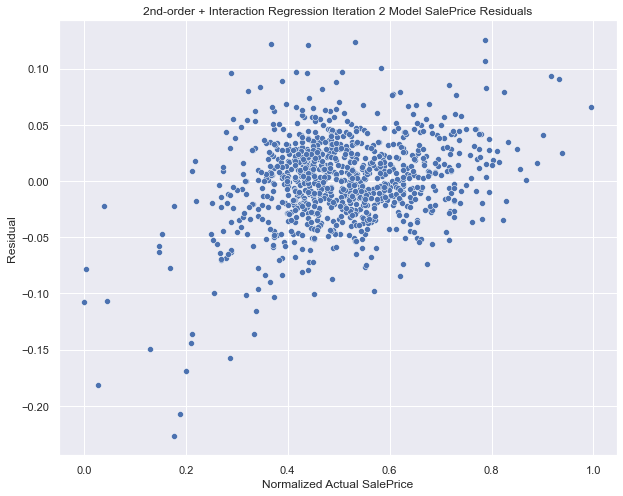

In [15]:
# Call the function to plot the residuals
plot_residuals(results_SOIR_iter2, y_SOIR_iter2_train, 'Iteration 2')

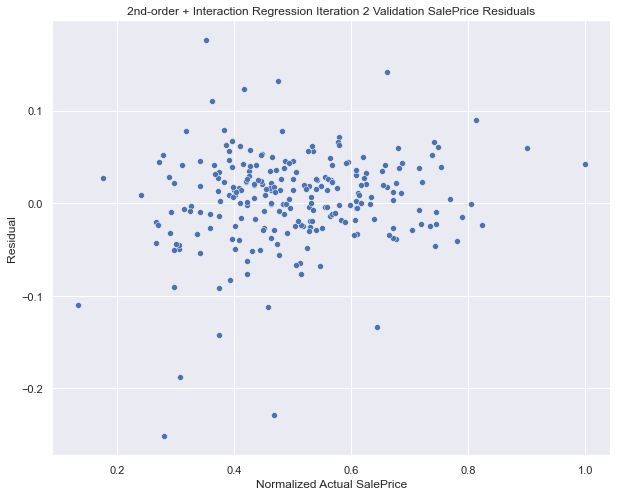

In [16]:
# Also call the function to plot the residuals using the validation set:
plot_validation_residuals(results_SOIR_iter2, X_SOIR_iter2_validate_const, y_SOIR_iter2_validate, 'Iteration 2')

Analysis of the results from the second iteration of this model:
- Collinearity is no longer an issue.
- There are a few more features that are not significant at 95% confidence and can be removed from the next iteration of the model:
    - MasVnrType, FullBath, BedroomAbvGr
- As with the linear regression, the second iteration has worse R<sup>2</sup> and RMSE scores than the first, suggesting it may be an inferior fit.
- Residual plots look similar to the first iteration of the model fitting.

#### Third iteration of second order with interaction terms regression with more features removed:

In [17]:
# Copy the training data once again into a new dataframe
train_SOIR_iter3 = train_SOIR.copy()

In [18]:
# Append tuple with insignificant features with those observed to be not significant with second iteration of model
SOIR_iter3_insig = ('LotShape',
                    'LotConfig',
                    'RoofStyle',
                    'Exterior1st',
                    'ExterQual',
                    'FireplaceQu',
                    'MoSold',
                    'BsmtCond',
                    'LotFrontage + LotArea',
                    'LotFrontage + YearBuilt',
                    'LotFrontage + GrLivArea',
                    'LotArea + GrLivArea',
                    'YearBuilt + GrLivArea',
                    'GrLivArea + OverallQual',
                    'MasVnrType',
                    'FullBath',
                    'BedroomAbvGr')
# Use this tuple to remove these features from the data set
train_SOIR_iter3 = train_SOIR_iter3.loc[:,~train_SOIR_iter3.columns.str.startswith(SOIR_iter3_insig)]

# Repeat the same process as before to handle features to be remove whose name contains "^":
SOIR_iter3_insig_sqr = ['LotFrontage^2','LotArea^2','YearBuilt^2','OverallQual^2']
for train_drop_col_name in SOIR_iter3_insig_sqr:
    train_SOIR_iter3 = train_SOIR_iter3.loc[:,~train_SOIR_iter3.columns.str.contains(train_drop_col_name, regex = False)]

In [19]:
# Once again, obtain a list of column names to split the data into X and y
train_SOIR_iter3_col_list = train_SOIR_iter3.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_SOIR_iter3 = train_SOIR_iter3.loc[:,train_SOIR_iter3_col_list[1]:train_SOIR_iter3_col_list[-1]]
# Now store the first column as y
y_SOIR_iter3 = train_SOIR_iter3.loc[:,train_SOIR_iter3_col_list[0]]
# Split data into training and validation sets:
X_SOIR_iter3_train, X_SOIR_iter3_validate, y_SOIR_iter3_train, y_SOIR_iter3_validate = train_test_split(X_SOIR_iter3, y_SOIR_iter3, test_size = 0.2, random_state = 42, shuffle = True)

In [20]:
# Add the constant column to both the training and validation sets:
X_SOIR_iter3_train_const = sm.add_constant(X_SOIR_iter3_train)
X_SOIR_iter3_validate_const = sm.add_constant(X_SOIR_iter3_validate)

In [21]:
# Train & fit the model using the training data:
model_SOIR_iter3 = sm.OLS(y_SOIR_iter3_train, X_SOIR_iter3_train_const)
results_SOIR_iter3 = model_SOIR_iter3.fit()
# Print results summary
print(results_SOIR_iter3.summary())
# Call the function to print RMSE & R^2 values
RMSE_and_R_sq(results_SOIR_iter3, X_SOIR_iter3_train_const, X_SOIR_iter3_validate_const, y_SOIR_iter3_train, y_SOIR_iter3_validate)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     120.4
Date:                Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:37:19   Log-Likelihood:                 1731.3
No. Observations:                 952   AIC:                            -3305.
Df Residuals:                     873   BIC:                            -2921.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

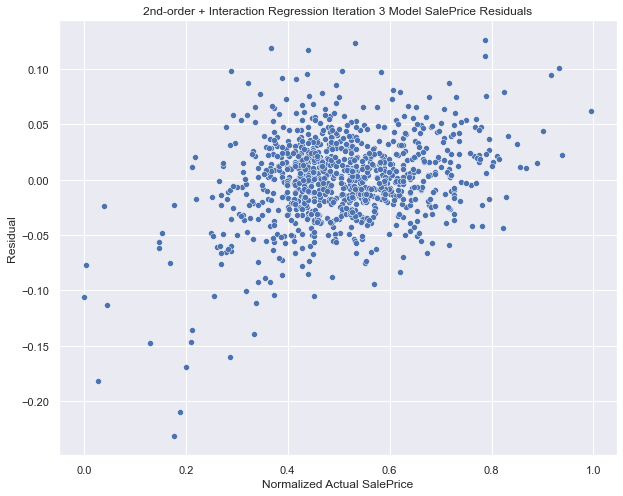

In [22]:
# Call the function to plot the residuals
plot_residuals(results_SOIR_iter3, y_SOIR_iter3_train, 'Iteration 3')

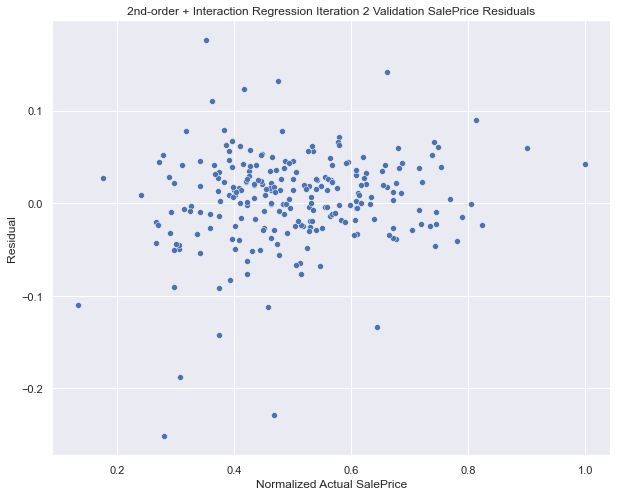

In [23]:
# Also call the function to plot the residuals using the validation set:
plot_validation_residuals(results_SOIR_iter2, X_SOIR_iter2_validate_const, y_SOIR_iter2_validate, 'Iteration 2')

Analysis of the third iteration of the 2nd order + iteration term regression model:
- Other than HalfBath, all of the remaining coefficients are or (in the case of categorical features) have at least one level that is significant at 95% confidence.
- Similar to the linear regression model, the R<sup>2</sup> and RMSE scores are both worse for the third iteration than the second iteration. However, unlike the linear regression model, the change was greater between the 1<sup>st</sup> -> 2<sup>nd</sup> iteration.
- The residual plots are still basically unchanged from the first iteration.

#### Summary of the validation set R<sup>2</sup>, RMSE, and test set score:

| Model Iteration | Validation R<sup>2</sup> | Validation RMSE | Test Set Score (log RMSE) |
| --- | -: | -: | -: |
| Iteration 1 | 0.869 | 0.0497 | 0.15229 |
| Iteration 2 | 0.865 | 0.0504 | 0.15141 |
| Iteration 3 | 0.864 | 0.0507 | 0.15157 |

The test set scores are obtained from submitting predicted values for sale price for the data in the test data set on Kaggle.

It is the second iteration of this regression model that scored the best (lowest log RMSE) with the test set. (The difference in the order of magnitudes between the validation and test RMSE might be due different logarithms being chosen for transformation; the evaluation notes only indicate "logarithm" and don't specify what the base used was. The comparison is probably being done with data that aren't normalized, either.) However, once again the validation R<sup>2</sup> and RMSE do not appear to be doing a satisfactory job predicting the minima for the test set. It is still unclear what is causing this.

Let's also examine at the coefficient magnitudes of from the 2nd iteration of second order with interaction terms regression model to see which features impact sale price the greatest.

In [24]:
# First get coefficients (params) from regression model
coeff_SOIR_iter2 = results_SOIR_iter2.params
# Take absolute value since magnitude is of interest
coeff_SOIR_iter2_abs = abs(coeff_SOIR_iter2)
# Sort by absolute value and then only display the ten coefficients with the greatest impact to sale price
coeff_SOIR_iter2_df = pd.DataFrame({'Coeff':coeff_SOIR_iter2, 'abs(Coeff)':coeff_SOIR_iter2_abs})
coeff_SOIR_iter2_df_sorted = coeff_SOIR_iter2_df.sort_values(by = 'abs(Coeff)', ascending = False)
coeff_SOIR_iter2_df_sorted.drop(columns = 'abs(Coeff)').head(10)

,Coeff
LotArea + OverallQual,0.390831
GrLivArea^2,0.274643
YearBuilt,0.250175
OverallQual,0.207120
LotArea + YearBuilt,-0.194103
LotFrontage + OverallQual,-0.186809
YearBuilt + OverallQual,-0.159343
MSZoning_RH,0.143272
MSZoning_FV,0.135518
MSZoning_RL,0.122700


Recall from the linear regression model, the features with the largest impact on sale price were house square footage (by a large margin), followed by the house quality and lot size. There are some similarities here, but the inclusion of interaction terms complicates the interpretation slightly.

The interaction term between lot size & house quality is has the greatest impact on sale price. This interaction term is probably best described as positive changes in house quality and lot size positively impact house sale price. Given that the house quality by itself has the fourth largest impact on sale price, and lot size does not appear by itself in the top 10, it seems plausible that house quality is the main driving force for the sale price, but house lots also benefits sale price as the house quality increases.

The second largest coefficient correspond to the square of house square footage, indicated that as the house size increases, the sale price also increase, but the effect becomes more pronounced with larger homes (e.g. 1 square foot more for a 1000 sq. ft. house is worth less than the same increase for a 3000 sq. ft. house).

Year of house construction is also quite relevant to sale price, although it did not appear in the top ten coefficients with greatest magnitudes for the linear regression analysis. The EDA suggested that it should be relevant, as it was apparent that newer homes were sold for more than older homes in general.

The remainder of the list is composed of more interation terms of the top features (as well as LotFrontage, which could be argued to be related to LotArea), as well as several levels of the zoning classification, which also appeared in the same list for the linear regression analysis. However, these interactions are _negative_ in sign, which means the combination of these terms will inversely impact sale price. For example (LotArea + YearBuilt), newer and smaller houses _or_ older and larger houses would be predicted to sell for more than houses that had values for both of these features near their respective medians, since these conditions will reduce the magnitude of this model term.

#### This concludes the regression analysis. Now let's see if machine learning can do a better job modeling the data and predicting the test set sale prices.